 ## Il classificatore Baesyano come approccio linguistico alla individuazione automatica delle Fake News pt.1
 
L'elaborato nasce dalla volontà di scoprire, utilizzando algoritmi di machine learning e data mining, quali siano gli attributi caratteristici delle fake news, e se è possibile utilizzare un metodo automatico per comprendere se un testo è falso o vero. 

L'obbiettivo di questo progetto è quello di allenare un classificatore Baesyano su un dataset di notizie, composto da due fold: uno di fake news, e l'altro di notizie vere, ponendosi come vincolo l'attuazione di tutte le strategie per rendere il risultato il più accurato e robusto possibile.

Il dataset utilizzato è interamente in lingua inglese ed è stato creato utilizzando [snopes](www.snopes.com) come fonte; il sito giornalistico è stato scelto in quanto affidabile e soprattuto perchè contiene il link agli articoli di fake news originali, facendo si che la base dati utilizzata per questo progetto sia effettivamente quella che gli utenti si trovano davanti navigando in rete. 

La classificazione avverà su due base dati differenti:
1) Dataset non pre-processato, ovvero gli articoli verranno analizzati 'as is', senza manipolazione; 
2) Dataset pre-processato, ovvero al testo degli articoli verranno applicati tutti gli accorgimenti per disambiguare il significato delle parole all'interno del testo (Tokenizzazione - POS Tagging - Lemmatizzazione).

Questa seconda analisi viene effettuata su una classificazione con preprocessing, nella quale verranno analizzati gli articoli manipolati: essi infatti subiranno un processo di tokenizzazione (verranno eliminati gli spazi), un processo di POS Tagging (ovvero verrà applicato un tag specifico a ogni parola in base alla sua categoria grammaticale) e un processo di lemmatizzazione (ovvero ogni parola verrà ridotta alla sua forma canonica). 
Questo preprocessing si prevede aumenterà il carattere informativo di ogni feature: sopratutto in lingua inglese infatti, la stessa parola può avere significati diversi, quindi differenziandone le varie sfumature di significato, si potrà avere un potere di generalizazione migliore.

In [1]:
import nltk 
from nltk import *
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from nltk.corpus import wordnet as wn
import pandas as pd
import re, string
from nltk.stem import WordNetLemmatizer
from __future__ import print_function

wnl = WordNetLemmatizer()

def univ_pos_changer(stringa):
    if stringa=="NOUN":
        return "n"
    elif stringa=="VERB":
        return "v"
    elif stringa=="ADJ":
        return "a"
    elif stringa=="ADV":
        return "r"
    else:
        return None

def my_lemmatizer(frase):
    lista1 = []
    for parole in frase:
        word =parole.split("__")[0].lower()
        tag = parole.split("__")[1]

        if univ_pos_changer(tag) == None:
            lista1.append(wnl.lemmatize(word.replace("_",""))+"__"+tag)
        elif(wn.morphy(word,univ_pos_changer(tag)) == None):
            lista1.append(wnl.lemmatize(word.replace("_",""))+"__"+tag)
        else:
            lista1.append(wn.morphy(word,univ_pos_changer(tag))+"__"+tag)
    return lista1

La metodologia di caricamento del dataset è la medesima del programma precedente, mentre in questo caso viene aggiunta una parte dedita alla lemmatizzazione.
Per la lemmatizzazione viene utilizzato Wordnet, in due casi differenti. 
Nel primo caso, per nomi, verbi, aggettivi e avverbi, si utilizza la funzione morphy(), mentre per il resto viene utilizzata la funzione lemmatize() di WordNetLemmatizer().
La funzione univ_pos_tagger() viene utilizzata per 'tradurre' i tag dalla forma utilizzata da nltk alla forma utilizzata da Wordnet (nltk tagga i nomi come"NOUN", mentre Wordy prevede tag monocarattere, quindi "n".)

In [2]:
import nltk
from nltk import *
import random 
from nltk.corpus.reader import CategorizedPlaintextCorpusReader

file = "snopes/dataset"
collCategorized= CategorizedPlaintextCorpusReader(file, r'.*\.txt', cat_pattern=r'(\w+)/*')
documents1 =[(list(collCategorized.words(fileid)), category) for category in collCategorized.categories() for fileid in collCategorized.fileids(category)]

random.shuffle(documents1)
print("Articoli totali: {}".format(len(documents1)))

Articoli totali: 1127


Il caricamento del dataset avviene utilizzando la stessa procedura del programma precedente. 

In [3]:
corpus = []
corpus_tagged = []
i = 0;
for j in documents1:
    text = j[0]
    cat = j[1]
    tagged = nltk.pos_tag(word_tokenize(" ".join(text)),tagset="universal")
    corpus.append(([a.replace("_","").replace("_","")+"__"+b.replace("_","") for a,b in tagged],cat))
    corpus_tagged.append((my_lemmatizer(corpus[i][0]),corpus[i][1]))
    i = i+1
    print("\r{}° articoli di {} POS taggati! \r".format(i,len(documents1)), end='')

La tokenizzazione e il POS Tagging avvengono utilizzando le funzioni di nltk. Il delimitatore tra parola è tag è un doppio carattere speciale  , che poi sarà lemmatizzato dalla funzione my_lemmatizer() vista in precedenza. 
Il dataset finale (ovvero corpus_tagged) quindi sarà composto da: 
######  [(articolo ,categoria), (articolo1,categoria1) ... (articolon,categorian)]
con articolo compreso di:

######  [parola_tag, parola1_tag1, ... , parolan_tagn].

con articolo s'intende un articolo fisico all'interno del dataset 'Snopes'

con parola s'intende un elemento all'interno dell'articolo 

con tag s'intende la categoria grammaticale che identifica la parola,  

con categoria s'intende la tipologia d'appartenenza dell'articolo, intesa come 'fake' o 'legit'.

TAG analysis on corpus:


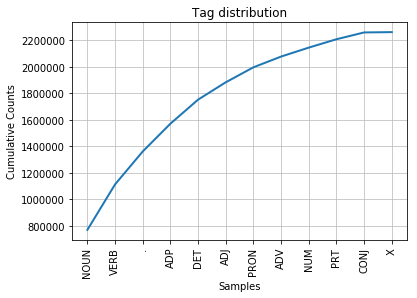

  NOUN   VERB      .    ADP    DET    ADJ   PRON    ADV    NUM    PRT   CONJ      X 
770157 342773 248129 209353 181437 130653 113075  81025  67495  62986  51365   2459 


In [4]:
import matplotlib.pyplot as plt
print("TAG analysis on corpus:")
stat = []
count = 0
dev = []
false = []
true = []
while count < len(corpus_tagged):
    if corpus_tagged[count][1]=="legit":
        for i in corpus_tagged[count][0]:
            true.append((i.split("__")[0],i.split("__")[1]))
    if corpus_tagged[count][1]=="fake":
        for i in corpus_tagged[count][0]:
            false.append((i.split("__")[0],i.split("__")[1]))
    for i in corpus_tagged[count][0]:
            stat.append((i.split("__")[0],i.split("__")[1]))
    count = count +1
    
fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.title('Tag distribution')

tag_fd = nltk.FreqDist(tag for (word,tag) in stat)
tag_fd.most_common()
tag_fd.plot(cumulative=True)
tag_fd.tabulate()
plt.show()
fig.savefig("Tag_distribution",dpi=400)

Il POS tag è avvenuto con successo, e il grafico mostra la distribuzione dei tag all'interno del corpus.

Con NOUN s'intende i sostantivi 

con VERB s'intende verbi lemmatizzati

con . s'intende la punteggiatura 

con ADP s'intende le apposizioni

con DET s'intende gli articoli determinativi e indeterminativi

con ADJ s'intende gli aggettivi

con PRON s'intende i pronomi

con ADV s'intende gli avverbi

con NUM s'intende le cifre 

con PRT s'intende le particelle

con CONJ s'intende le congiunzioni 

con X s'intende le parole che non appartengono a nessuna categoria grammaticale sopra riportata (errori di battitura, emotiocon...)

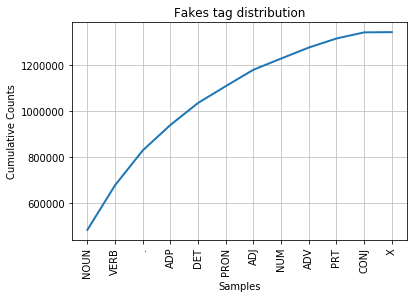

  NOUN   VERB      .    ADP    DET   PRON    ADJ    NUM    ADV    PRT   CONJ      X 
481497 194666 151771 111208  96094  73230  71651  48773  48088  39497  26713   1155 


In [5]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.title('Fakes tag distribution')

tag_fd = nltk.FreqDist(tag for (word,tag) in false)
tag_fd.most_common()
tag_fd.plot(cumulative=True)
tag_fd.tabulate()

plt.show()
fig.savefig("Tag_fakes_distribution",dpi=400)

Grafico che mostra la distribuzione dei tag all'interno degli articoli di categoria 'FAKE'.
Si nota come vi è un forte utilizzo della punteggiatura.

Tag distribution of trues


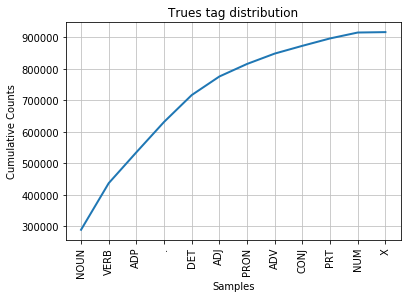

  NOUN   VERB    ADP      .    DET    ADJ   PRON    ADV   CONJ    PRT    NUM      X 
288660 148107  98145  96358  85343  59002  39845  32937  24652  23489  18722   1304 


In [6]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.title('Trues tag distribution')

tag_fd = nltk.FreqDist(tag for (word,tag) in true)
tag_fd.most_common()
print("Tag distribution of trues")
tag_fd.plot(cumulative=True)
tag_fd.tabulate()

plt.show()
fig.savefig("Tag_trues_distribution",dpi=400)

Grafico che mostra la distribuzione dei tag all'interno degli articoli di categoria 'TRUE'.

In [7]:
words = []
for articoli in corpus_tagged:
    for testo in articoli[0]: 
        words.append(testo)

listaFreq=nltk.FreqDist(w for w in words)
word_features=[x for (x,_) in listaFreq.most_common()]
    
def document_features(document,a,b):
    document_words=set(document)
    features={}
    for word in word_features:
        features["contains({})".format(word)]=(word in document_words)
    return features

print("Numero totale parole: {} \nGrandezza dizionario: {}".format(len(words),len(listaFreq)))

Numero totale parole: 2260907 
Grandezza dizionario: 33263


Viene creata la lista di frequenze delle parole all'interno del corpus: essa verrà utilizzata nella creazione delle features.
Utilizzando una tecnica di POS Tagging, la lunghezza del dizionario è cambiata: da 31907 del primo progetto si arriva a 33375, facendo rimanere invariato il numero di parole totali; in questo modo è aumentato il valore informativo di ogni parola, in quanto è stato differenziato il significato.

In [8]:
featuresets_doc=[(document_features(d,0,len(listaFreq.most_common())), c) for (d, c) in corpus_tagged]
size = int(len(featuresets_doc) * 0.9)
train_set_doc, test_set_doc = featuresets_doc[size:], featuresets_doc[:size]
classifier_doc=nltk.NaiveBayesClassifier.train(train_set_doc)

print("Accuratezza classificazione: {}".format(nltk.classify.accuracy(classifier_doc, test_set_doc)*100))
range_data = nltk.classify.accuracy(classifier_doc, test_set_doc)*100
classifier_doc.show_most_informative_features(10)

Accuratezza classificazione: 89.15187376725838
Most Informative Features
        contains('__PRT) = True             fake : legit  =     25.7 : 1.0
     contains(who__NOUN) = True             fake : legit  =     15.7 : 1.0
contains(recommend__VERB) = True             fake : legit  =     15.7 : 1.0
   contains(share__NOUN) = True             fake : legit  =     15.2 : 1.0
      contains(no__NOUN) = True             fake : legit  =     14.1 : 1.0
          contains('__.) = True             fake : legit  =     13.4 : 1.0
  contains(google__NOUN) = True             fake : legit  =     12.4 : 1.0
  contains(device__NOUN) = True             fake : legit  =     12.4 : 1.0
     contains(how__NOUN) = True             fake : legit  =     12.4 : 1.0
        contains(0__NUM) = True             fake : legit  =     11.7 : 1.0


La classificazione segue le stesse regole della precedente, e ci permette di avere una prima analisi: 
la classificazione senza preprocessing ha avuto un'accuratezza di circa 80%, mentre utilizzando il preprocessing si ha una classificazione del 89.84%, ovvero migliore di circa del 9%.
La differenziazione del significato di ogni singola parola e la sua lemmatizzazione ha giocato un ruolo chiave nel migliorare la prestazione.

In [9]:
print("Cross validation on 10 fold:")
from sklearn import cross_validation
cv = cross_validation.KFold(len(train_set_doc), n_folds=10, shuffle=False, random_state=None)
i = 1
for traincv, evalcv in cv:
    classifier = nltk.NaiveBayesClassifier.train(train_set_doc[traincv[0]:traincv[len(traincv)-1]])
    print('Accuracy '+str(i)+'° fold: %.3f' % nltk.classify.util.accuracy(classifier, train_set_doc[evalcv[0]:evalcv[len(evalcv)-1]]))  
    i = i+1

Cross validation on 10 fold:


C:\Users\matteo.mazzola\Downloads\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy 1° fold: 0.818
Accuracy 2° fold: 1.000
Accuracy 3° fold: 0.818
Accuracy 4° fold: 1.000
Accuracy 5° fold: 1.000
Accuracy 6° fold: 1.000
Accuracy 7° fold: 1.000
Accuracy 8° fold: 1.000
Accuracy 9° fold: 1.000
Accuracy 10° fold: 0.900


La crossvalidation è un metodo di verifica della bontà di una classificazione: l'intero insieme di feature viene diviso in folds, ovvero parti più piccole del dataset in cui verrà praticata la classificazione. Questo permette di mettere in luce errori dovuti  alla scarsa generalizzazione del modello: se i risultati attraverso i vari fold non sono troppo differenti, allora la classificazione si può definire robusta. 

La classificazione sull'intero dataset porta un'accuratezza circa dell'89%. 

Ma è questa l'accuratezza massima che può avere il modello? 

## Test sull'accuratezza della classificazione

La base dati di una classificazione ottimale non comprende tutti gli elementi all'interno del dataset: più feature si sono, più si rischia di diluire le vere evidenze della categoria con feature dal valore informativo basso o nullo. 
Questo è facilmente intuibile pensando a come parole dal basso contenuto informativo, come articoli o congiunzioni, siano molto più frequenti rispetto a elementi altamente informativi, come verbi o nomi.
Per questo motivo è necessario trovare una porzione di frequenza la quale classificazione dia un'accuratezza massima, in modo da avere una buona sorgente di informazioni il più predittive possibile della categoria a cui si riferiscono. 
La ricerca di questo range non può essere che effettuata mediante valutazioni empiriche: di seguito vi è la divisione delle parole più frequenti in porzioni dall'ampiezza variabile, in modo da verificare quando si ha un'accuratezza maggiore.

La frequenza relativa delle parole è stata divisa in slices:

    partendo da 0 con il primo slice da 500, porzioni da 100 (0-500, 500-600, 600-700 ...)
    
    partendo da 0 con il primo slice da 700, porzioni da 100 (0-700, 700-800, 800-900 ...)
    
    partendo da 0, slice da 500 incrementali (0-5000, 0-1000, 0,1500 ...)
    
    partendo da 0, porzioni da 500 (0-500, 500-1000, 1000-1500 ...)
    
    partendo da 0, porzioni da 700 (0-700, 7000-1400, 700-1400 ...)
    
    partendo da 0, porzioni da 1000 (0-1000, 1000-2000, 2000-3000 ...)

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def test_Accuracy(principio, final,parte,veces,caja,incr):
    x = 1
    while(x <= count):
        featuresets_doc=[(document_features(d,principio,final), c) for (d, c) in corpus_tagged]
        size = int(len(featuresets_doc) * 0.9)
        train_set_doc, test_set_doc = featuresets_doc[size:], featuresets_doc[:size]
        classifier_doc=nltk.NaiveBayesClassifier.train(train_set_doc)
        print("\r{}° Range: {} to {} most frequent words, Accuracy: {}".format(x,principio,final,nltk.classify.accuracy(classifier_doc, test_set_doc)*100),end='')
        caja.append(nltk.classify.accuracy(classifier_doc, test_set_doc)*100)
        if (incr==True):
            principio,final = principio+parte,final+parte
        else:
            principio,final = principio,final+parte
        x = x+1
    return caja

def dibujar(caja,count,parte):
    print("\n Grafico 1 in corso...")
    plt.plot(caja,'r')
    plt.xlabel("Range: {} word".format(parte))
    plt.ylabel("Accuracy")
    plt.show()
    print("\n Grafico 2 in corso...")    
    plt.plot(caja, 'r--o')
    plt.axis([0,count,10,100])
    plt.xlabel("Range: {} word".format(parte))
    plt.ylabel("Accuracy")
    plt.show()
    
def document_features(document,principio,final):
    document_words=set(document)
    features={}
    word_features=[x for (x,_) in listaFreq.most_common()[principio:final]]
    for word in word_features:
        features["contains({})".format(word)]=(word in document_words)
    return features

La segmentazione delle frequenze avviene nella funzione test_Accuracy, nella quale ripetiamo per 15 volte una classificazione su uno slice sempre diverso di frequenze, in modo da osservare l'andamento dell'accuratezza in base al variare delle parole in ingresso.
In questo modo si tolgono dalla classificazione parole sempre più frequenti e si aggiungono parole sempre meno frequenti, trovando alla fine una finestra di compromesso. 

Dibujar è la funzione che ci permette di visualizzare il risultato di ogni classificazione attraverso un grafico.

15° Range: 1400 to 1900 most frequent words, Accuracy: 82.84023668639054
 Grafico 1 in corso...


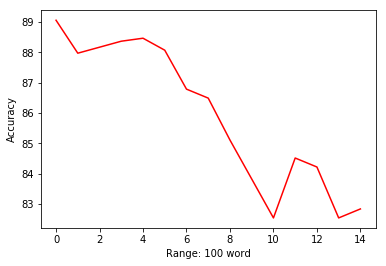


 Grafico 2 in corso...


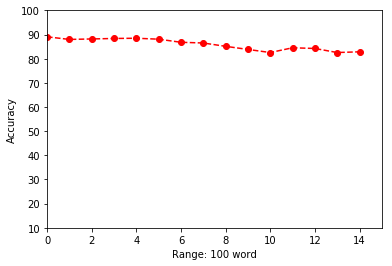

,Accuracy Accuracy 0-500 con slice 100
0,89.053254
1,87.968442
2,88.165680
3,88.362919
4,88.461538
5,88.067061
6,86.785010
7,86.489152
8,85.108481
9,83.826430


In [11]:
a = 0
b = 500
r = 100
count = 15
res_s0_e500_r100 = []
dibujar(test_Accuracy(a,b,r,count,res_s0_e500_r100,True),count,r)
pd1 = pd.DataFrame({"Accuracy Accuracy 0-500 con slice 100":res_s0_e500_r100})
pd1

15° Range: 1400 to 2100 most frequent words, Accuracy: 84.91124260355029
 Grafico 1 in corso...


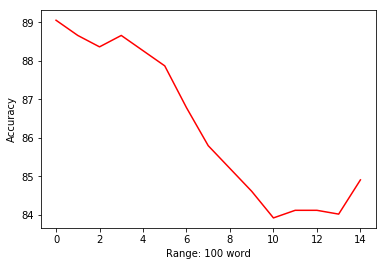


 Grafico 2 in corso...


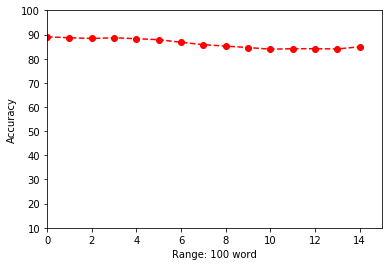

,Accuracy 0-700 con slice 100
0,89.053254
1,88.658777
2,88.362919
3,88.658777
4,88.264300
5,87.869822
6,86.785010
7,85.798817
8,85.207101
9,84.615385


In [12]:
a = 0
b = 700
r = 100
count = 15
res_s0_e700_r100 = []
dibujar(test_Accuracy(a,b,r,count,res_s0_e700_r100,True),count,r)
pd2 = pd.DataFrame({"Accuracy 0-700 con slice 100":res_s0_e700_r100})
pd2

15° Range: 0 to 7500 most frequent words, Accuracy: 87.67258382642999
 Grafico 1 in corso...


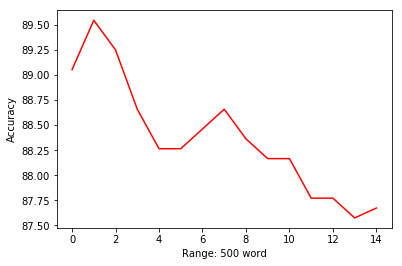


 Grafico 2 in corso...


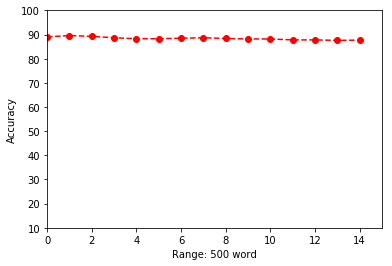

,Accuracy 0-500 con slice 500 incrementale
0,89.053254
1,89.546351
2,89.250493
3,88.658777
4,88.264300
5,88.264300
6,88.461538
7,88.658777
8,88.362919
9,88.165680


In [13]:
a = 0
b = 500
r = 500
count = 15
res_s0_e500_r500_incremental = []
dibujar(test_Accuracy(a,b,r,count,res_s0_e500_r500_incremental,False),count,r)
pd3 = pd.DataFrame({"Accuracy 0-500 con slice 500 incrementale":res_s0_e500_r500_incremental})
pd3

15° Range: 7000 to 7500 most frequent words, Accuracy: 63.905325443786985
 Grafico 1 in corso...


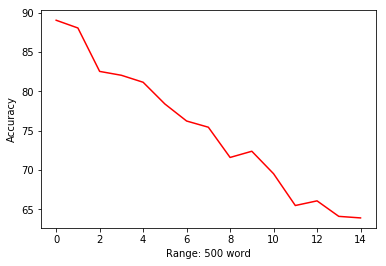


 Grafico 2 in corso...


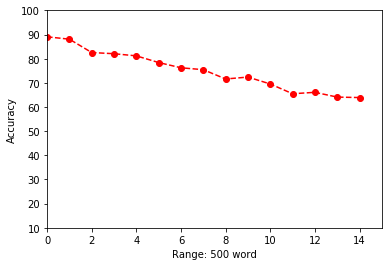

,Accuracy 0-500 con slice di 500
0,89.053254
1,88.067061
2,82.544379
3,82.051282
4,81.163708
5,78.402367
6,76.232742
7,75.443787
8,71.597633
9,72.386588


In [14]:
a = 0
b = 500
r = 500
count = 15
res_s0_e500_r500 = []
dibujar(test_Accuracy(a,b,r,count,res_s0_e500_r500,True),count,r)
pd4 = pd.DataFrame({"Accuracy 0-500 con slice di 500":res_s0_e500_r500})
pd4

15° Range: 9800 to 10500 most frequent words, Accuracy: 68.04733727810651
 Grafico 1 in corso...


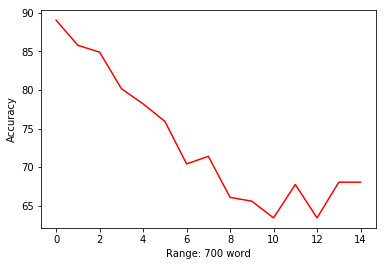


 Grafico 2 in corso...


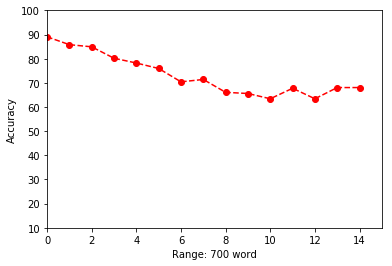

,Accuracy 0-700 con slice di 700
0,89.053254
1,85.798817
2,84.911243
3,80.177515
4,78.205128
5,75.936884
6,70.414201
7,71.400394
8,66.074951
9,65.581854


In [15]:
a = 0
b = 700
r = 700
count = 15
res_s0_e700_r700 = []
dibujar(test_Accuracy(a,b,r,count,res_s0_e700_r700,True),count,r)
pd5 = pd.DataFrame({"Accuracy 0-700 con slice di 700":res_s0_e700_r700})
pd5

15° Range: 14000 to 15000 most frequent words, Accuracy: 50.39447731755424
 Grafico 1 in corso...


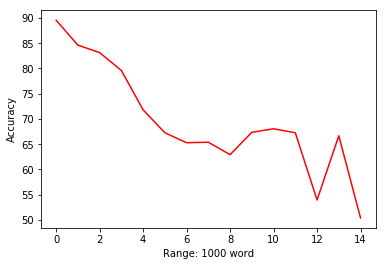


 Grafico 2 in corso...


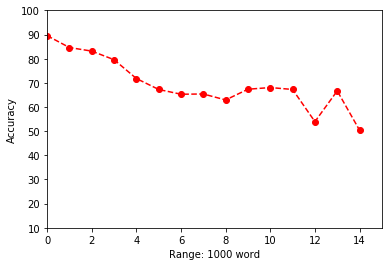

,Accuracy 0-1000 con slice di 1000
0,89.546351
1,84.615385
2,83.136095
3,79.585799
4,71.794872
5,67.258383
6,65.285996
7,65.384615
8,62.919132
9,67.357002


In [16]:
a = 0
b = 1000
r = 1000
count = 15
res_s0_e1000_r1000 = []
dibujar(test_Accuracy(a,b,r,count,res_s0_e1000_r1000,True),count,r)
pd6 = pd.DataFrame({"Accuracy 0-1000 con slice di 1000":res_s0_e1000_r1000})
pd6

In [32]:
pd1.join(pd2).join(pd3).join(pd4).join(pd5).join(pd6)

,Accuracy Accuracy 0-500 con slice 100,Accuracy 0-700 con slice 100,Accuracy 0-500 con slice 500 incrementale,Accuracy 0-500 con slice di 500,Accuracy 0-700 con slice di 700,Accuracy 0-1000 con slice di 1000
0,89.053254,89.053254,89.053254,89.053254,89.053254,89.546351
1,87.968442,88.658777,89.546351,88.067061,85.798817,84.615385
2,88.165680,88.362919,89.250493,82.544379,84.911243,83.136095
3,88.362919,88.658777,88.658777,82.051282,80.177515,79.585799
4,88.461538,88.264300,88.264300,81.163708,78.205128,71.794872
5,88.067061,87.869822,88.264300,78.402367,75.936884,67.258383
6,86.785010,86.785010,88.461538,76.232742,70.414201,65.285996
7,86.489152,85.798817,88.658777,75.443787,71.400394,65.384615
8,85.108481,85.207101,88.362919,71.597633,66.074951,62.919132
9,83.826430,84.615385,88.165680,72.386588,65.581854,67.357002


La tabella riassuntiva dell'accuratezza del modello: si nota come essa varia in maniera limitata quando considera le feature a massima frequenza, mentre cala in maniera vistosa quando la classificazione si effettua su feature con frequenza più bassa.
Con un dataset preprocessato, le distribuzioni sono più robuste, ovvero vi è meno margine di variazione, rispetto a un dataset non preprocessato.

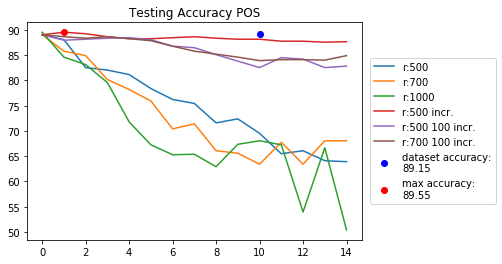

In [44]:
import matplotlib.pyplot as plt
import numpy as np
p = res_s0_e500_r500 + res_s0_e700_r700 + res_s0_e1000_r1000 + res_s0_e500_r500_incremental + res_s0_e500_r100 + res_s0_e700_r100

maximo = 0
for i in p:
    if (i > maximo):
        maximo = i
        
fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.title('Testing Accuracy POS')

ax.plot(res_s0_e500_r500, label='r:500')
ax.plot(res_s0_e700_r700, label='r:700')
ax.plot(res_s0_e1000_r1000, label='r:1000')
ax.plot(res_s0_e500_r500_incremental, label='r:500 incr.')
ax.plot(res_s0_e500_r100, label='r:500 100 incr.')
ax.plot(res_s0_e700_r100, label='r:700 100 incr.')
ax.plot(10,range_data,'bo', label='dataset accuracy:\n{}'.format(round(range_data,2)))
ax.plot(1,maximo,'ro', label='max accuracy:\n{}'.format(round(maximo,2)))
handles,labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,loc='right', bbox_to_anchor=(1.4,0.5),borderaxespad=0)
plt.show()

fig.savefig("Testing_Accuracy_POS",bbox_extra_artists=(lgd,), bbox_inches='tight',dpi=400)

Il grafico mostra come, allontanandosi dalle feature iniziali, l'accuratezza diminuisce, mentre gli slice di accuratezza migliore considerano parole ad alta frequenza. 
Il risultato di questo 'slicing' ci porta ad osservare che l'accuratezza migliore è di 89.55% riscontrata nella sezione 0-1000.

L'obbiettivo è sempre quello di migliorare la classificazione, aggiustando la finestra ideale di feature nella quale effettuare la classificazione. A scaglioni di 50 feature, si verifica l'accuratezza del modello sulla base dati equivalente.

In [26]:
def document_featureshuffle(document,principio,final):
    document_words=set(document)
    features={}
    word_features=[x for (x,_) in listaFreq.most_common()[principio:final]]
    random.shuffle(word_features)
    random.shuffle(word_features)
    for word in word_features:
        features["contains({})".format(word)]=(word in document_words)
    return features

In [46]:
begin = 0
final = 1000
final_more = []
final_less = []


begin_more = []
begin_less = []
count = 10
hace = True
jump = 50
if (begin==0):
    hace = False
i = 1
print("\nFrom {} to {}: from the end up to {} words".format(begin,final,jump))
while i <= count:
    featuresets_doc=[(document_featureshuffle(d,begin,final), c) for (d, c) in corpus_tagged]
    size = int(len(featuresets_doc) * 0.9)
    train_set_doc, test_set_doc = featuresets_doc[size:], featuresets_doc[:size]
    classifier_doc=nltk.NaiveBayesClassifier.train(train_set_doc)
    print("\r{}° slice: from {} to {}, accuracy: {}".format(i,begin,final,nltk.classify.accuracy(classifier_doc, test_set_doc)*100),end='')
    final_more.append(nltk.classify.accuracy(classifier_doc, test_set_doc)*100)
    final = final + jump
    i = i+1
pd_end_up = pd.DataFrame({"Accuracy end up to 50":final_more})

begin = 0
final = 1000
i = 1
print("\nFrom {} to {}: from the end down to {} words".format(final,begin,jump))
while i <= count:
    featuresets_doc=[(document_featureshuffle(d,begin,final), c) for (d, c) in corpus_tagged]
    size = int(len(featuresets_doc) * 0.9)
    train_set_doc, test_set_doc = featuresets_doc[size:], featuresets_doc[:size]
    classifier_doc=nltk.NaiveBayesClassifier.train(train_set_doc)
    print("\r{}° slice: from {} to {}, accuracy: {}".format(i,begin,final,nltk.classify.accuracy(classifier_doc,test_set_doc)*100),end='')
    final_less.append(nltk.classify.accuracy(classifier_doc, test_set_doc)*100)
    final = final - jump
    i = i+1 
pd_end_down = pd.DataFrame({"Accuracy end down to 50":final_less})

begin = 0
final = 1000
i = 1    
print("\nFrom {} to {}: from the beginning up to {} words".format(begin,final,jump))
while i <= count:
    featuresets_doc=[(document_featureshuffle(d,begin,final), c) for (d, c) in corpus_tagged]
    size = int(len(featuresets_doc) * 0.9)
    train_set_doc, test_set_doc = featuresets_doc[size:], featuresets_doc[:size]
    classifier_doc=nltk.NaiveBayesClassifier.train(train_set_doc)
    print("\r{}° slice: from {} to {}, accuracy: {}".format(i,begin,final,nltk.classify.accuracy(classifier_doc, test_set_doc)*100),end='')
    begin_more.append(nltk.classify.accuracy(classifier_doc, test_set_doc)*100)
    begin = begin + 50
    i = i+1
pd_begin_up = pd.DataFrame({"Accuracy begin up to 50":begin_more})

begin = 0
final = 1000
i = 1
if (hace):
    print("\nFrom {} to {}: from the beginning down of {} words".format(final,begin - jump*10,jump))
    while i <= count:
            featuresets_doc=[(document_featureshuffle(d,begin,final), c) for (d, c) in corpus_tagged]
            size = int(len(featuresets_doc) * 0.9)
            train_set_doc, test_set_doc = featuresets_doc[size:], featuresets_doc[:size]
            classifier_doc=nltk.NaiveBayesClassifier.train(train_set_doc)
            print("\r{}° slice: from {} to {}, accuracy: {}".format(i,begin,final,nltk.classify.accuracy(classifier_doc, test_set_doc)*100),end='')
            begin_less.append(nltk.classify.accuracy(classifier_doc, test_set_doc)*100)
            begin = begin - 50
            i = i+1
    pd_begin_down = pd.DataFrame({"Accuracy begin down to 50":begin_less})
else:
    pd_begin_down = pd.DataFrame({"Accuracy begin down to 50":[]})


From 0 to 1000: from the end up to 50 words
10° slice: from 0 to 1450, accuracy: 89.05325443786982
From 1000 to 0: from the end down to 50 words
10° slice: from 0 to 550, accuracy: 89.05325443786982
From 0 to 1000: from the beginning up to 50 words
10° slice: from 450 to 1000, accuracy: 89.3491124260355

In [47]:
pd_end_up.join(pd_end_down).join(pd_begin_up).join(pd_begin_down)

,Accuracy end up to 50,Accuracy end down to 50,Accuracy begin up to 50,Accuracy begin down to 50
0,89.546351,89.546351,89.546351,NaN
1,89.546351,89.250493,88.757396,NaN
2,89.546351,89.546351,88.856016,NaN
3,89.644970,89.447732,88.461538,NaN
4,89.447732,89.250493,88.362919,NaN
5,89.053254,89.447732,88.165680,NaN
6,88.757396,89.053254,88.658777,NaN
7,88.856016,89.053254,88.362919,NaN
8,88.856016,89.151874,88.165680,NaN
9,89.053254,89.053254,89.349112,NaN


Si noti come l'ultima colonna sia vuota in quanto lo slice prende in considerazione tutte le parole a massima frequenza, quindi non vi è possibilità di aggiungerne altre.

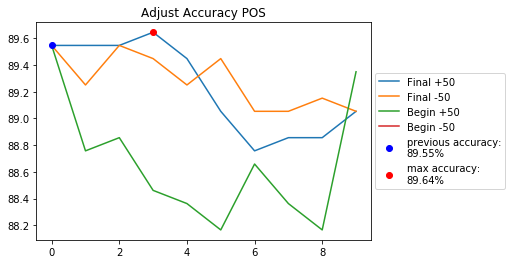

In [51]:
import matplotlib.pyplot as plt
import numpy as np
p_ =  final_more+final_less+begin_more+begin_less

maximo_ = 0
for i in p_:
    if (i > maximo_):
        maximo_ = i

fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.title('Adjust Accuracy POS')
ax.plot(final_more, label="Final +50")
ax.plot(final_less, label="Final -50")
ax.plot(begin_more, label="Begin +50")
ax.plot(begin_less, label="Begin -50")

ax.plot(0,maximo,'bo', label='previous accuracy:\n{}%'.format(round(maximo,2)))
ax.plot(3,maximo_,'ro', label='max accuracy:\n{}%'.format(round(maximo_,2)))

handles,labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,loc='right', bbox_to_anchor=(1.4,0.5),borderaxespad=0)
plt.show()

fig.savefig("Adjust_Accuracy_POS",bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)

Il grafico mostra come si è raggiunta una accuratezza ancora migliore, nella finestra 0:1150.
Dal grafico si evidenzia come, togliendo feature ad alta frequenza dalla classificazione, l'accuratezza scenda drasticamente. 

In conclusione: analizzando l'andamento dell'accuratezza della classificazione, si nota come la finestra con l'accuratezza maggiore si abbia nello slice di frequenze 0:1150.

Si è dimostrato come il preprocessing aumenti l'accuratezza della classificazione, e si è concluso che le parole più utili per la differenziazione tra fake news e legit news si trovano nello slice 0:1150 del dataset, con accuratezza di 89.64%.